In [17]:
import numpy as np
import matplotlib.pyplot as plt
import geostochpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from pyproj import Geod
def generate_scenarios(M, n_slips, sigma_L=0.18**2, alpha_W=0.17**2):
    """
    Genera escenarios de longitud (L) y ancho (W) para un evento sísmico dado.

    Parámetros:
    M (float): Magnitud del evento sísmico.
    num_scenarios (int): Número de escenarios a generar.
    sigma_L (float): Desviación estándar para log10(L).
    alpha_W (float): Desviación estándar para log10(W).
    Paper:"Scaling Relations of Earthquake Source Parameter Estimates
        with Special Focus on Subduction Environment
        by Lilian Blaser, Frank Krüger, Matthias Ohrnberger, and Frank Scherbaum"
    Retorna:
    list: Lista de tuplas (L, W) con los escenarios generados.
    """
    # Ecuaciones para log10(L) y log10(W)
    mu_L = -2.37 + 0.57 * M
    mu_W = -1.86 + 0.46 * M

    # Generar valores de log10(L) y log10(W)
    log10_L = np.random.normal(mu_L, sigma_L, n_slips)
    log10_W = np.random.normal(mu_W, alpha_W, n_slips)

    # Convertir log10(L) y log10(W) a L y W
    L = 10 ** log10_L
    W = 10 ** log10_W
    W[W > 180] = 180
    # Combinar L y W en una lista de escenarios
    scenarios = list(zip(L, W))
    return scenarios
def calculate_cell_areas_km2(X_grid, Y_grid):
    # Crear una instancia del elipsoide WGS84 para cálculos geodésicos
    geod = Geod(ellps="WGS84")
    
    # Inicializar una matriz para almacenar las áreas de las celdas en km²
    areas_km2 = np.zeros((X_grid.shape[0] - 1, X_grid.shape[1] - 1))
    
    for i in range(X_grid.shape[0] - 1):
        for j in range(X_grid.shape[1] - 1):
            # Definir los cuatro vértices del polígono (celda)
            polygon = Polygon([
                (Y_grid[i, j], X_grid[i, j]),           # Punto superior izquierdo
                (Y_grid[i, j+1], X_grid[i, j+1]),       # Punto superior derecho
                (Y_grid[i+1, j+1], X_grid[i+1, j+1]),   # Punto inferior derecho
                (Y_grid[i+1, j], X_grid[i+1, j]),       # Punto inferior izquierdo
            ])
            
            # Calcular el área del polígono en metros cuadrados
            area_m2, _ = geod.geometry_area_perimeter(polygon)
            
            # Convertir el área a kilómetros cuadrados
            areas_km2[i, j] = area_m2 / 1e6
    
    # Crear una nueva matriz para incluir la última fila y columna
    extended_areas_km2 = np.zeros((areas_km2.shape[0] + 1, areas_km2.shape[1] + 1))
    
    # Copiar las áreas calculadas en la nueva matriz
    extended_areas_km2[:-1, :-1] = areas_km2
    
    # Completar la última fila y columna con los valores de la penúltima
    extended_areas_km2[-1, :-1] = areas_km2[-1, :]
    extended_areas_km2[:-1, -1] = areas_km2[:, -1]
    
    # El último valor (esquina inferior derecha) lo completamos con el de la esquina superior derecha
    extended_areas_km2[-1, -1] = areas_km2[-1, -1]
    
    return extended_areas_km2
def plot_mesh(X_grid, Y_grid, X_grid_new, Y_grid_new, Slip, epicenter, ax=None, cmapslip='rainbow',title='Slip Distribution'):
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    # Agregar datos de topografía (shaded relief) en escala de grises
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_extent([X_grid.min()-1, X_grid.max()+1, Y_grid.min()-1, Y_grid.max()+1])
    ax.pcolormesh(X_grid, Y_grid, np.zeros(X_grid.shape), cmap='binary', transform=ccrs.PlateCarree(), edgecolors='k', linewidths=0.1, antialiased=True, shading='auto', alpha=0.5)
    mesh = ax.pcolormesh(X_grid_new, Y_grid_new, Slip, cmap=cmapslip, transform=ccrs.PlateCarree(), antialiased=True, shading='gouraud')
    
    # Agregar barra de color si no es un subplot compartido
    if ax.get_subplotspec().is_last_row():
        plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.03, pad=0.05)
    
    ax.scatter(epicenter[0], epicenter[1], s=50, marker='*', color='yellow', transform=ccrs.PlateCarree(), edgecolors='k', linewidths=0.5)
    ax.set_title(title)
    # Solo mostrar el gráfico si ax no fue proporcionado
    if ax is None:
        plt.show()



In [53]:
import random
from scipy.interpolate import griddata
# Adjust the scenarios inside of the mesh
#ex with meshgrid_Iquique.npz
data='meshgrid_Concepcion.npz'
mesh=np.load(data)
median_lock=np.loadtxt('Chile_locking.txt')
median_lock = median_lock[~np.isnan(median_lock).any(axis=1)]
x=median_lock[:,0]
y=median_lock[:,1]
z=median_lock[:,2]
slabcoupling=np.column_stack((x, y, z))

#save the data in variables as the same name of mesh.files
X_grid=mesh['X_grid']
Y_grid=mesh['Y_grid']
dep=mesh['dep']
dip=mesh['dip']
strike=mesh['strike']
rake=mesh['rake']
length=mesh['length']
width=mesh['width']
dx=mesh['dx']
dy=mesh['dy']
nx=mesh['nx']
ny=mesh['ny']
print("length",length)
taper_coupling= griddata((slabcoupling[:,0], slabcoupling[:,1]), slabcoupling[:,2], (X_grid, Y_grid), method='linear', fill_value=0.5, rescale=True)



length 666.0


Scenario 1 : (464.71958651691335, 179.53663723978065)
-72.30018851249481 -32.969588597038346 13910.872645092259
3.181425858421483
11.684470271762372 7.6665593434605475


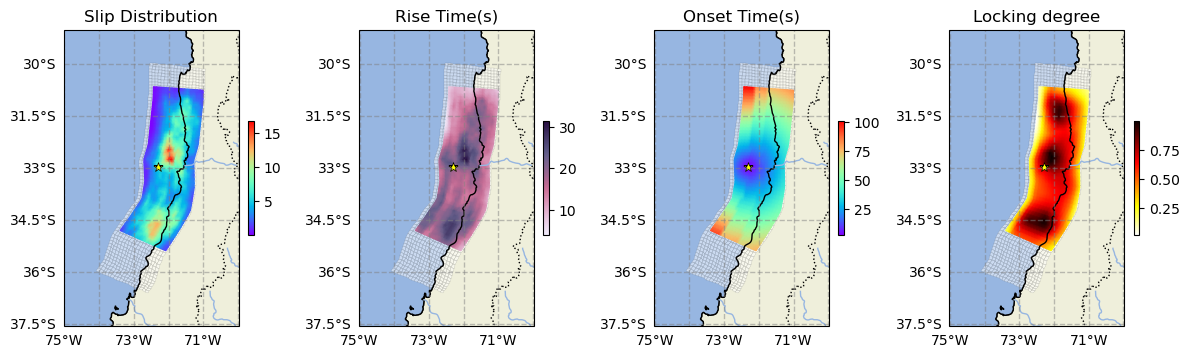

In [113]:
#generate the scenarios
Mw=8.8
scenarios = generate_scenarios(Mw, 1)
for i in range(len(scenarios)):
    print("Scenario",i+1,":",scenarios[i])
    length2 = scenarios[i][0]
    if length2>length:
        length2=length
        print("The length of the scenario is bigger than the mesh, the length was adjusted to the mesh length")
    width2 = scenarios[i][1]
    northlat = np.max(Y_grid)
    southlat = np.min(Y_grid)
    new_ny=int(length2/dy)
    new_nx=int(width2/dx)
    # Selecciona aleatoriamente el índice inicial del rango
    start_index_nx = random.randint(0, nx-new_nx)
    start_index_ny = random.randint(0, ny-new_ny)
    # Define el índice final basado en el índice inicial
    def slice_matrix(matrix, start_ny, start_nx, new_ny, new_nx):
        return matrix[start_ny:start_ny + new_ny, start_nx:start_nx + new_nx]

    slices = [X_grid, Y_grid, dep, dip, strike, rake, taper_coupling]
    sliced_results = [slice_matrix(matrix, start_index_ny, start_index_nx, new_ny, new_nx) for matrix in slices]

    X_grid_new, Y_grid_new, dep_new, dip_new, strike_new, rake_new, taper_coupling_new = sliced_results
    # tuple of files of the folder base
    villarroel_taper = geostochpy.taper_except_trench_tukey(dep_new, alpha_dip=0.3, alpha_strike=0.3)
    taper_coupling_new = taper_coupling_new * villarroel_taper
    areas = calculate_cell_areas_km2(X_grid_new, Y_grid_new)
    media, rigidez = geostochpy.media_slip_area(Mw, dx * 1000, dy * 1000,areas, dep_new)
    mu = geostochpy.matriz_medias_villarroel(media, taper_coupling_new)
    C = geostochpy.matriz_covarianza_von_karman(dip_new, dep_new, X_grid_new, Y_grid_new, length2, width2)
    Slip = geostochpy.distribucion_slip_optimizada(C, mu, new_nx*new_ny-1)
    Slip, rigidez, Mo_original, Mo_deseado = geostochpy.escalar_magnitud_momento(Mw, Slip, dep_new, dy * 1000, dx * 1000, prem=True)
[x,y,z]=geostochpy.hypocenter(X_grid_new,Y_grid_new,dep_new,length2,width2)
epicenter=[x,y]
print(x,y,z)
vs,prof=geostochpy.load_PREM()
# interp z with prof to obtain vs
from scipy.interpolate import interp1d
f = interp1d(prof, vs)
vs_hypocenter=f(z)/1000 # m2km
if z/1000 < 10:
    vr=0.56*vs_hypocenter
elif z/1000 > 15:
    vr=0.8*vs_hypocenter
    # to between this values, apply a linear transition in rupture speed
else:
    # make a linear transition between 0.56 and 0.8 
    vr=(0.048*z/1000+0.08 )  *vs_hypocenter
from scipy.interpolate import griddata
VR=np.zeros_like(dep_new)
# interp z with prof to obtain vs
VS=f(dep_new)/1000
for row in range(dep_new.shape[0]):  # Recorre las filas
    for col in range(dep_new.shape[1]):  # Recorre las columnas
        if dep_new[row, col] < 10:
            VR[row, col] = 0.56*VS[row, col]
        elif dep_new[row, col] > 15:
            VR[row, col] = 0.8*VS[row, col]
        elif dep_new[row, col] >= 10 and dep_new[row, col] <= 15:
            VR[row]=(0.048*z/1000+0.08 )  *VS[row, col]
# podemos calcular el tiempo de ruptura(onset time) con la velocidad de ruptura y la distancia al hipocentro
# X_grid_new, Y_grid_new, dep_new , epicenter, vr
xdistance=np.abs(X_grid_new-x)*111.111
ydistance=np.abs(Y_grid_new-y)*111.111
zdistance=np.abs(dep_new-z)/1000
distance=np.sqrt(xdistance**2+ydistance**2+zdistance**2)
onset_time=distance/VR
print(np.mean(VR.flatten()))
from cmcrameri import cm
# average risetime to entire fault T_a
T_a=4.308*10**(-7)*Mo_deseado**(1/3)
Mo_deseado_dyna=Mo_deseado*10**(7)
T_a2=0.82*1.6*10**(-9)*Mo_deseado_dyna**(1/3)
print(T_a,T_a2)
# risetime, T_i
# its function of slip of each subfault, and the dep of each subfault
# 2*T_a*sqrt(s_i) if d_i<10 km
# T_a*sqrt(s_i) if <d_i>15 km
# else, linear transition

# else, linear transition
# s_i= slip of each subfault
# d_i= dep of each subfault
# Slip contains all subfault
s_i=Slip
d_i=dep_new/1000
T_i=np.zeros_like(s_i)

for row in range(d_i.shape[0]):  # Recorre las filas
    for col in range(d_i.shape[1]):  # Recorre las columnas
        if d_i[row, col] < 10:
            T_i[row, col] = 2 * T_a2 * np.sqrt(s_i[row, col])
        elif d_i[row, col] > 15:
            T_i[row, col] = T_a2 * np.sqrt(s_i[row, col])
        elif d_i[row, col] >= 10 and d_i[row, col] <= 15:
            T_i[row,col] = (-0.2*d_i[row,col]+4)*T_a2 * np.sqrt(s_i[row,col])
fig, axs = plt.subplots(1, 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 5))
plot_mesh(X_grid, Y_grid, X_grid_new, Y_grid_new, Slip, epicenter, ax=axs[0], title='Slip Distribution')
plot_mesh(X_grid, Y_grid, X_grid_new, Y_grid_new, T_i, epicenter, ax=axs[1], cmapslip=cm.acton_r, title='Rise Time(s)')
plot_mesh(X_grid, Y_grid, X_grid_new, Y_grid_new, onset_time, epicenter, ax=axs[2],title='Onset Time(s)')
plot_mesh(X_grid, Y_grid, X_grid_new, Y_grid_new,taper_coupling_new, epicenter,cmapslip='hot_r', ax=axs[3],title='Locking degree')
fig.tight_layout()
plt.show()


In [114]:
np.mean(T_i.flatten())

17.070578670094143